In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 6.29 MiB/s, done.
Updating files: 100% (4/4), done.


In [2]:
!ls german-traffic-sign

ls: cannot access 'german-traffic-sign': No such file or directory


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline
np.random.seed(0)

In [4]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [5]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [6]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

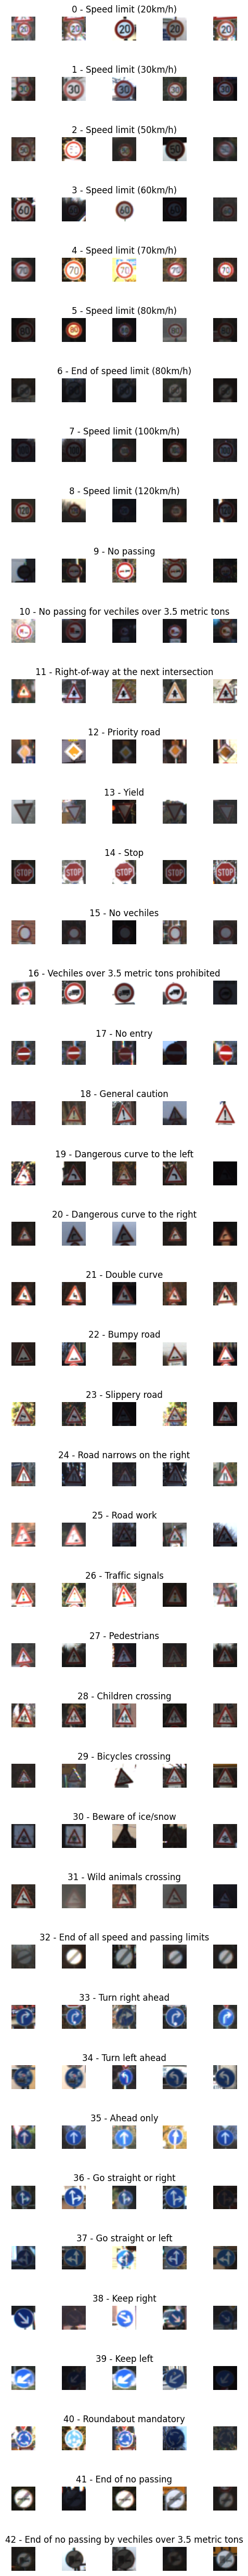

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
      for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


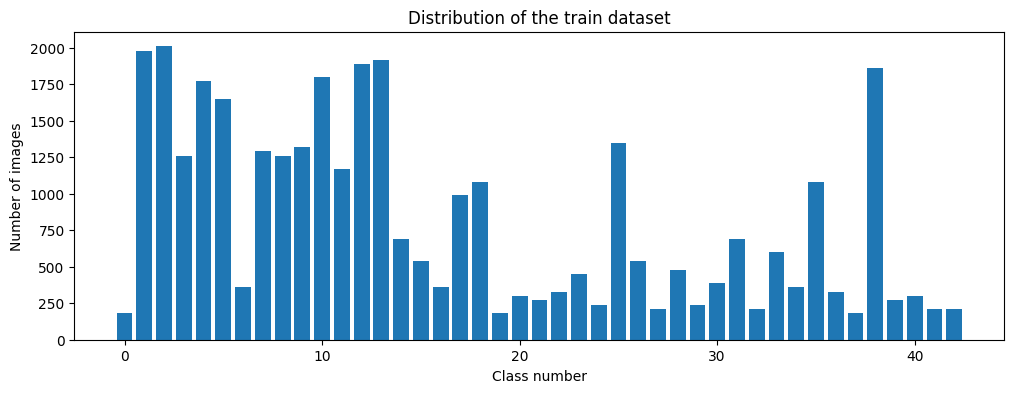

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


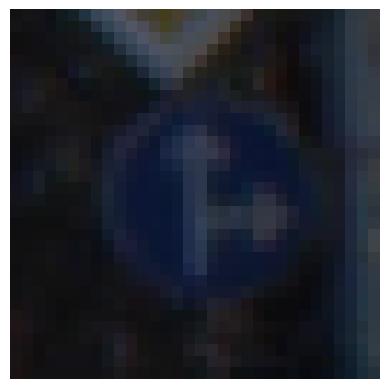

In [9]:
import cv2
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


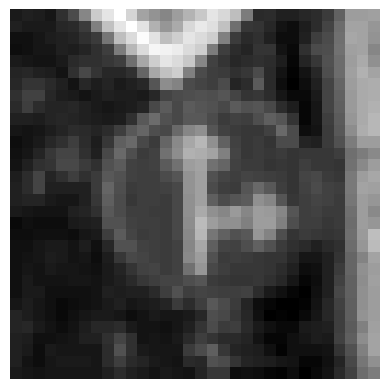

In [10]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

(32, 32)


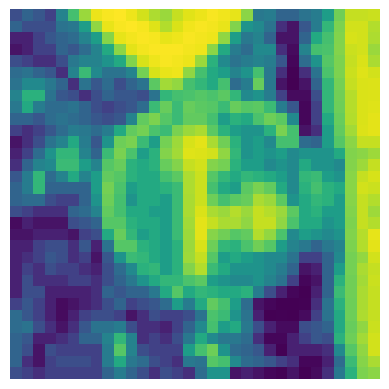

In [11]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)


In [12]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


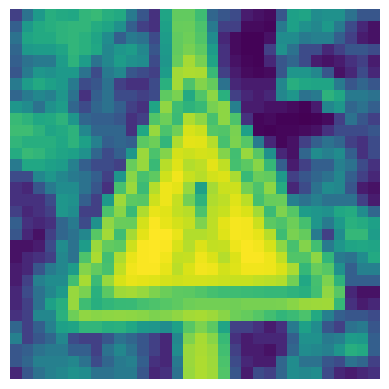

In [13]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [14]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
datagen.fit(X_train)

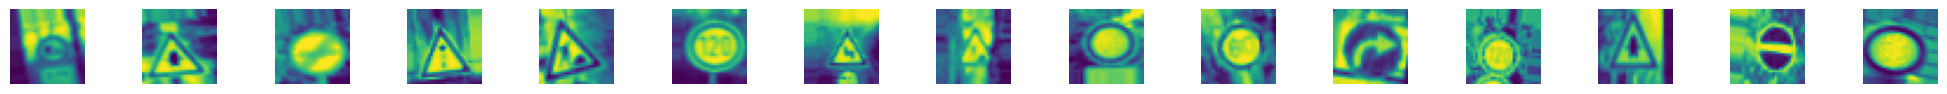

In [16]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [17]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [18]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [19]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr= 0.01), loss ='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [20]:
model = leNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 500)               2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 10s 13ms/step - loss: 2.6645 - accuracy: 0.2725 - val_loss: 1.2941 - val_accuracy: 0.5982
Epoch 2/10
87/87 [==============================] - 1s 7ms/step - loss: 1.0040 - accuracy: 0.6821 - val_loss: 0.7783 - val_accuracy: 0.7667
Epoch 3/10
87/87 [==============================] - 1s 7ms/step - loss: 0.6846 - accuracy: 0.7799 - val_loss: 0.6529 - val_accuracy: 0.8043
Epoch 4/10
87/87 [==============================] - 1s 7ms/step - loss: 0.5426 - accuracy: 0.8294 - val_loss: 0.5850 - val_accuracy: 0.8240
Epoch 5/10
87/87 [==============================] - 1s 7ms/step - loss: 0.4630 - accuracy: 0.8517 - val_loss: 0.5780 - val_accuracy: 0.8295
Epoch 6/10
87/87 [==============================] - 1s 7ms/step - loss: 0.4103 - accuracy: 0.8694 - val_loss: 0.5658 - val_accuracy: 0.8456
Epoch 7/10
87/87 [==============================] - 1s 7ms/step - loss: 0.3769 - accuracy: 0.8789 - val_loss: 0.4989 - val_accuracy: 0.8565
Epoch 8/10
87/87 [

Text(0.5, 0, 'epoch')

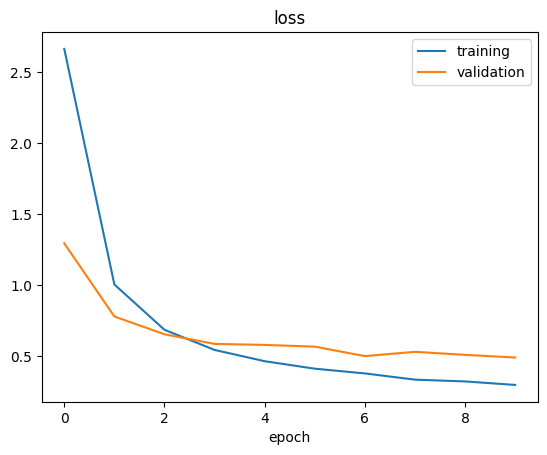

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

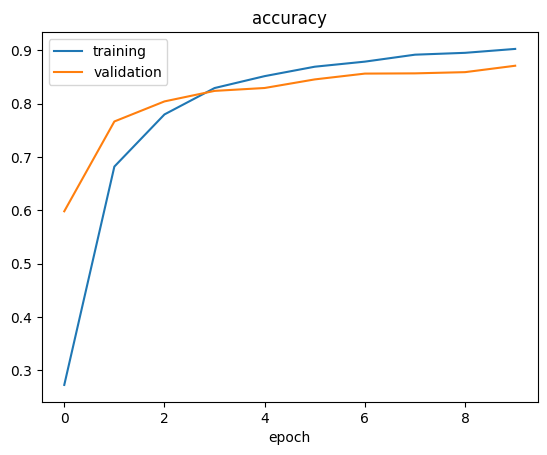

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [24]:
# Now we well do fine-tuning to obtain better accuracy in validation of the data

In [25]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr= 0.001), loss ='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [26]:
model = leNet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 540)               0         
                                                                 
 dense_2 (Dense)             (None, 500)              

In [27]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 2s 14ms/step - loss: 2.4605 - accuracy: 0.3513 - val_loss: 1.1911 - val_accuracy: 0.6705
Epoch 2/10
87/87 [==============================] - 1s 7ms/step - loss: 0.8524 - accuracy: 0.7410 - val_loss: 0.6415 - val_accuracy: 0.8181
Epoch 3/10
87/87 [==============================] - 1s 7ms/step - loss: 0.5017 - accuracy: 0.8494 - val_loss: 0.4388 - val_accuracy: 0.8721
Epoch 4/10
87/87 [==============================] - 1s 7ms/step - loss: 0.3540 - accuracy: 0.8937 - val_loss: 0.3799 - val_accuracy: 0.8887
Epoch 5/10
87/87 [==============================] - 1s 7ms/step - loss: 0.2690 - accuracy: 0.9204 - val_loss: 0.3361 - val_accuracy: 0.8961
Epoch 6/10
87/87 [==============================] - 1s 7ms/step - loss: 0.2102 - accuracy: 0.9383 - val_loss: 0.3008 - val_accuracy: 0.9136
Epoch 7/10
87/87 [==============================] - 1s 8ms/step - loss: 0.1731 - accuracy: 0.9497 - val_loss: 0.2760 - val_accuracy: 0.9181
Epoch 8/10
87/87 [=

In [28]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test Score:', score[0])


Test Score: 0.37500888109207153


In [29]:
score = model.evaluate(X_test, y_test, verbose = 1)

print('Test Accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.3750 - accuracy: 0.9051
Test Accuracy: 0.9050673246383667


In [30]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr= 0.001), loss ='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [31]:
model = leNet_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 60)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 30)        16230     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 30)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1080)              0         
                                                                 
 dense_4 (Dense)             (None, 500)              

In [32]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 2s 16ms/step - loss: 2.3052 - accuracy: 0.3850 - val_loss: 0.9290 - val_accuracy: 0.7404
Epoch 2/10
87/87 [==============================] - 1s 12ms/step - loss: 0.6860 - accuracy: 0.7914 - val_loss: 0.4894 - val_accuracy: 0.8556
Epoch 3/10
87/87 [==============================] - 1s 11ms/step - loss: 0.3721 - accuracy: 0.8884 - val_loss: 0.3397 - val_accuracy: 0.8950
Epoch 4/10
87/87 [==============================] - 1s 12ms/step - loss: 0.2459 - accuracy: 0.9255 - val_loss: 0.2809 - val_accuracy: 0.9122
Epoch 5/10
87/87 [==============================] - 1s 11ms/step - loss: 0.1832 - accuracy: 0.9458 - val_loss: 0.2386 - val_accuracy: 0.9313
Epoch 6/10
87/87 [==============================] - 1s 12ms/step - loss: 0.1371 - accuracy: 0.9598 - val_loss: 0.2124 - val_accuracy: 0.9277
Epoch 7/10
87/87 [==============================] - 1s 13ms/step - loss: 0.1121 - accuracy: 0.9678 - val_loss: 0.2109 - val_accuracy: 0.9304
Epoch 8/10
87

Text(0.5, 0, 'epoch')

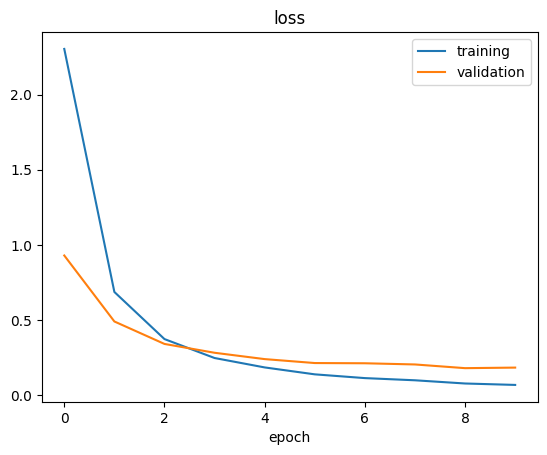

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

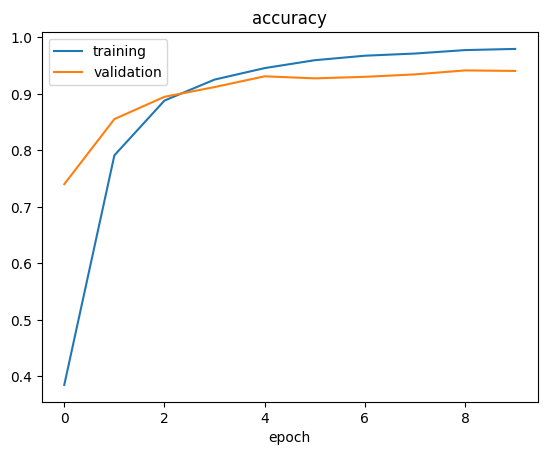

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [35]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test Score:', score[0])

Test Score: 0.29579609632492065


In [36]:
score = model.evaluate(X_test, y_test, verbose = 1)

print('Test Score:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.2958 - accuracy: 0.9269
Test Score: 0.9269200563430786


In [37]:
def modified_model(): # fine tuning again
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation ='relu'))
  model.add(Conv2D(30, (5, 5), activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr= 0.001), loss ='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [38]:
model = modified_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 30)        780       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 30)        22530     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 30)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 15)        4065      
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 15)          2040      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 15)         0         
 2D)                                                  

In [39]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 3s 21ms/step - loss: 2.2720 - accuracy: 0.3879 - val_loss: 0.7212 - val_accuracy: 0.7912
Epoch 2/10
87/87 [==============================] - 1s 13ms/step - loss: 0.5795 - accuracy: 0.8203 - val_loss: 0.3411 - val_accuracy: 0.8948
Epoch 3/10
87/87 [==============================] - 1s 15ms/step - loss: 0.3022 - accuracy: 0.9085 - val_loss: 0.2764 - val_accuracy: 0.9184
Epoch 4/10
87/87 [==============================] - 1s 15ms/step - loss: 0.2052 - accuracy: 0.9370 - val_loss: 0.2126 - val_accuracy: 0.9349
Epoch 5/10
87/87 [==============================] - 1s 13ms/step - loss: 0.1549 - accuracy: 0.9524 - val_loss: 0.1526 - val_accuracy: 0.9587
Epoch 6/10
87/87 [==============================] - 1s 13ms/step - loss: 0.1231 - accuracy: 0.9620 - val_loss: 0.1641 - val_accuracy: 0.9560
Epoch 7/10
87/87 [==============================] - 1s 14ms/step - loss: 0.0969 - accuracy: 0.9697 - val_loss: 0.1711 - val_accuracy: 0.9542
Epoch 8/10
87

In [40]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test Score:', score[0])

Test Score: 0.27208763360977173


In [41]:
score = model.evaluate(X_test, y_test, verbose = 1)

print('Test Score:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.2721 - accuracy: 0.9374
Test Score: 0.9373713135719299


In [42]:
def modified_model(): # fine tuning again
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation ='relu'))
  model.add(Conv2D(30, (5, 5), activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr= 0.001), loss ='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [43]:
model = modified_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 30)        780       
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 30)        22530     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 30)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 15)        4065      
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 15)          2040      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 15)         0         
 2D)                                                  

In [44]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 3s 22ms/step - loss: 2.8014 - accuracy: 0.2516 - val_loss: 1.1423 - val_accuracy: 0.6796
Epoch 2/10
87/87 [==============================] - 1s 16ms/step - loss: 1.0668 - accuracy: 0.6729 - val_loss: 0.4979 - val_accuracy: 0.8658
Epoch 3/10
87/87 [==============================] - 1s 16ms/step - loss: 0.6910 - accuracy: 0.7852 - val_loss: 0.3263 - val_accuracy: 0.9034
Epoch 4/10
87/87 [==============================] - 1s 16ms/step - loss: 0.5354 - accuracy: 0.8328 - val_loss: 0.2788 - val_accuracy: 0.9179
Epoch 5/10
87/87 [==============================] - 1s 16ms/step - loss: 0.4476 - accuracy: 0.8588 - val_loss: 0.2133 - val_accuracy: 0.9392
Epoch 6/10
87/87 [==============================] - 1s 16ms/step - loss: 0.3856 - accuracy: 0.8770 - val_loss: 0.1811 - val_accuracy: 0.9474
Epoch 7/10
87/87 [==============================] - 1s 16ms/step - loss: 0.3456 - accuracy: 0.8907 - val_loss: 0.1587 - val_accuracy: 0.9578
Epoch 8/10
87

In [45]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])

Test Score: 0.20648494362831116


In [46]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.2065 - accuracy: 0.9410
Test Score: 0.9410134553909302


Text(0.5, 0, 'epoch')

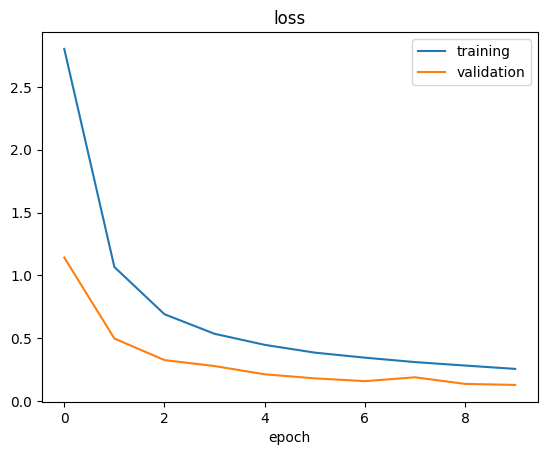

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

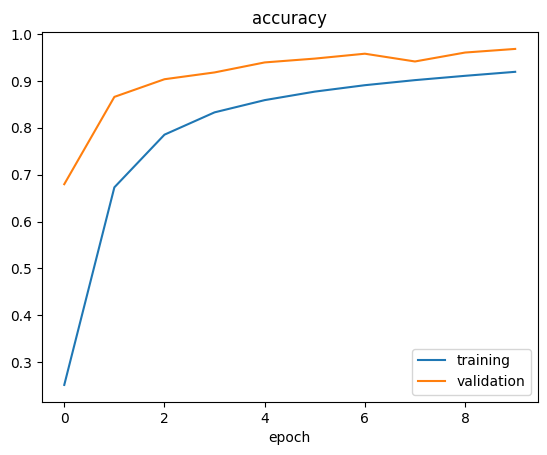

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')

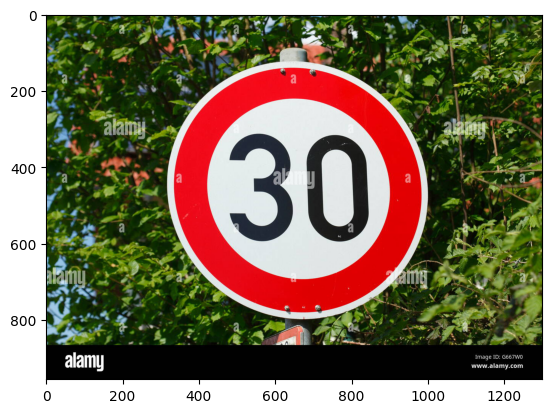

In [49]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))



(32, 32)


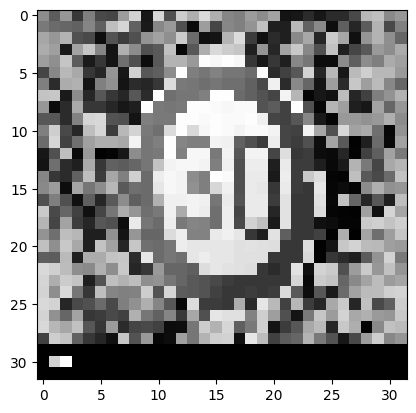

In [50]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)


In [51]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

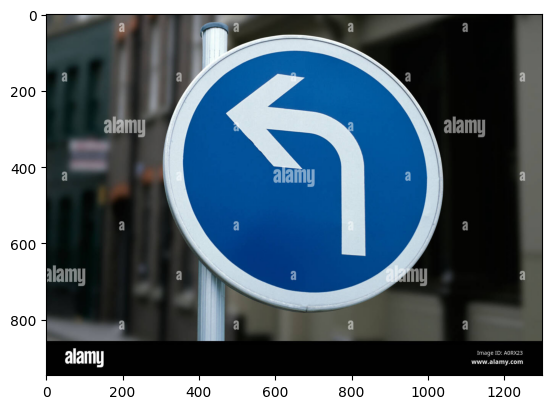

In [52]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


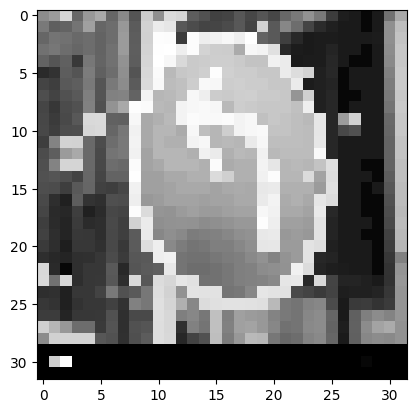

In [53]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [54]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

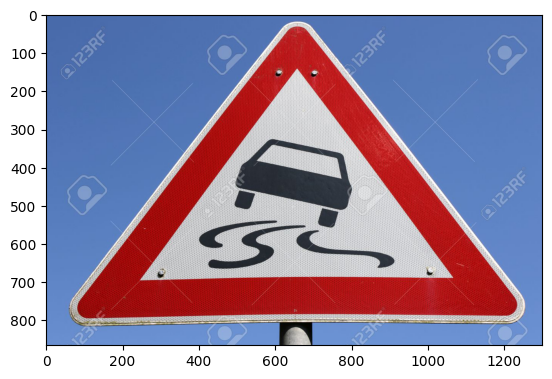

In [55]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


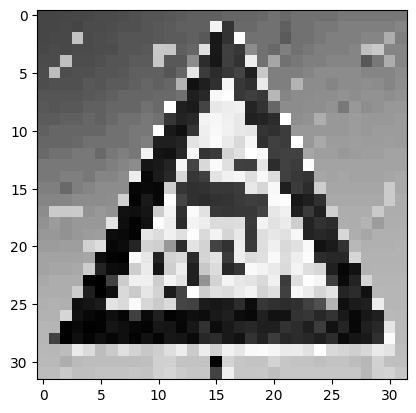

In [56]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [57]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

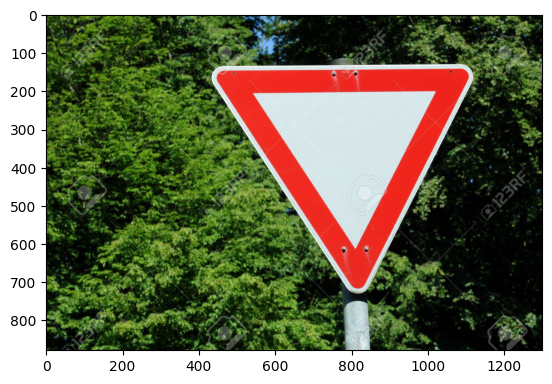

In [58]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


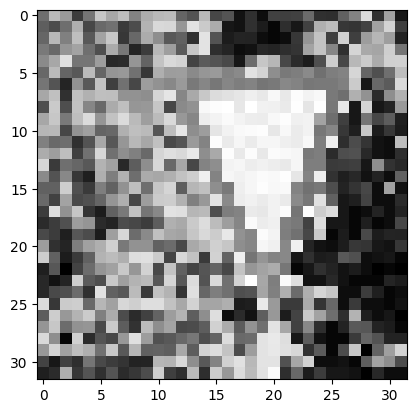

In [59]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [60]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

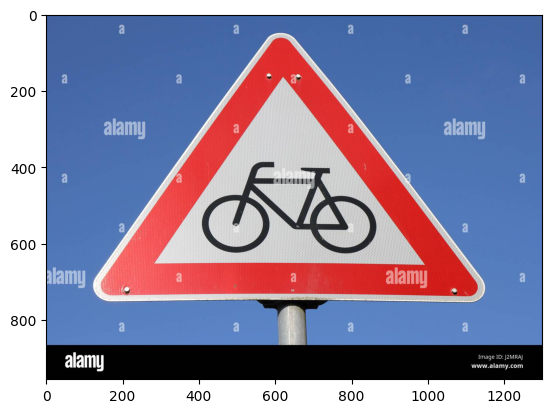

In [61]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


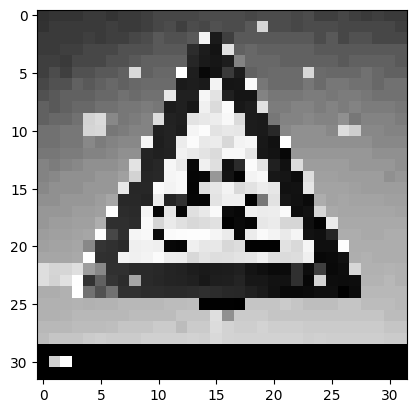

In [62]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [63]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [64]:
#Fit_generator
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val),shuffle = 1)

Epoch 1/10


<ipython-input-64-f5de16b2c030>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val),shuffle = 1)


 694/2000 [=========>....................] - ETA: 28s - loss: 1.2409 - accuracy: 0.6335

2000/2000 [==============================] - 17s 8ms/step - loss: 1.2404 - accuracy: 0.6337 - val_loss: 0.2391 - val_accuracy: 0.9465


In [65]:
#Fit_generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val),shuffle = 1)

Epoch 1/10
 695/2000 [=========>....................] - ETA: 28s - loss: 0.8478 - accuracy: 0.7378

2000/2000 [==============================] - 16s 8ms/step - loss: 0.8474 - accuracy: 0.7380 - val_loss: 0.1756 - val_accuracy: 0.9585
